# Permutation importance & calibration

В данном ноутбуке проверяется модель на переобученность и избыточность фичей с помощью permutation importance и uplift.

Далее проверяется калибровка результата модели.

Вход: предобработанные паркеты, набор признаков и гиперпараметры

Выход: обученная модель, график uplift и калибровки

In [1]:
import setproctitle

setproctitle.setproctitle("alex_permutation")

In [2]:
import gc
import os
import sys
import time

import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

tqdm.pandas()

In [3]:
samples = {
    k: pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet") for k in ["train", "oos", "oot"]
}

In [4]:
res = []
for k, v in samples.items():
    v = v[v['target'] != -1]
    res.append({
        'Выборка': k,
        'Размер': len(v),
        'Доля дефолтов': v['target'].mean(),
        'Минимальная дата': v['issue_d'].min(),
        'Максимальная дата': v['issue_d'].max(),
    })
res = pd.DataFrame(res)
res

,Выборка,Размер,Доля дефолтов,Минимальная дата,Максимальная дата
0,train,737965,0.201404,2012-09-01,2016-12-01
1,oos,315873,0.202464,2012-09-01,2016-12-01
2,oot,230990,0.236499,2017-01-01,2018-11-01


In [5]:
features = [
    # "inq_fi",
    # "all_util",
    "home_ownership",
    "log_annual_inc",
    "annual_inc",
    "num_rev_tl_bal_gt_0",
    "mort_acc",
    "funded_amnt_inv",
    "emp_title",
    "bc_open_to_buy",
    "debt_load",
    "fico_range_low",
    "fico_range_high",
]

cat_features = [
    "emp_title",
    "home_ownership",
    "verification_status",
    "purpose",
    "zip_code",
    "addr_state",
    "initial_list_status",
    "application_type",
    "verification_status_joint",
    "disbursement_method",
]
cat_features = sorted(set(cat_features) & set(features))
params = {
    "iterations": 400,
    "depth": 6,
    "l2_leaf_reg": 24.337217538245532,
    "learning_rate": 0.14119449759028455,
    "random_strength": 1.284731588293853,
    "rsm": 0.5363370106196876,
    "grow_policy": "SymmetricTree",
    "od_wait": 50,
    "eval_metric": "AUC",
    "logging_level": "Silent",
}

In [8]:
print(len(features))
print(*features, sep=', ')

11
home_ownership, log_annual_inc, annual_inc, num_rev_tl_bal_gt_0, mort_acc, funded_amnt_inv, emp_title, bc_open_to_buy, debt_load, fico_range_low, fico_range_high


In [8]:
pools = {
    k: catboost.Pool(v[v["target"] != -1][features], v[v["target"] != -1]["target"], cat_features=cat_features)
    for k, v in samples.items()
}
# pools['train'].quantize()
# pools['train'].save_quantization_borders('borders.dat')
# pools['oos'].quantize(input_borders='borders.dat')
# pools['oot'].quantize(input_borders='borders.dat')

# Train some model

In [9]:
clf = catboost.CatBoostClassifier(**params)
clf.fit(
    pools["train"],
    eval_set=pools["oos"],
    verbose=0,
    plot=True,
)
clf.save_model('catboost.cb')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [10]:
clf = catboost.CatBoostClassifier(**params)
clf.load_model('catboost.cb')

In [28]:
samples_woe = {
    k: pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}_with_score_WoE.parquet") for k in ["train", "oos", "oot"]
}

In [29]:
for k, v in samples_woe.items():
    samples_woe[k]['score_cb'] = clf.predict_proba(v[clf.feature_names_])[:, 1]

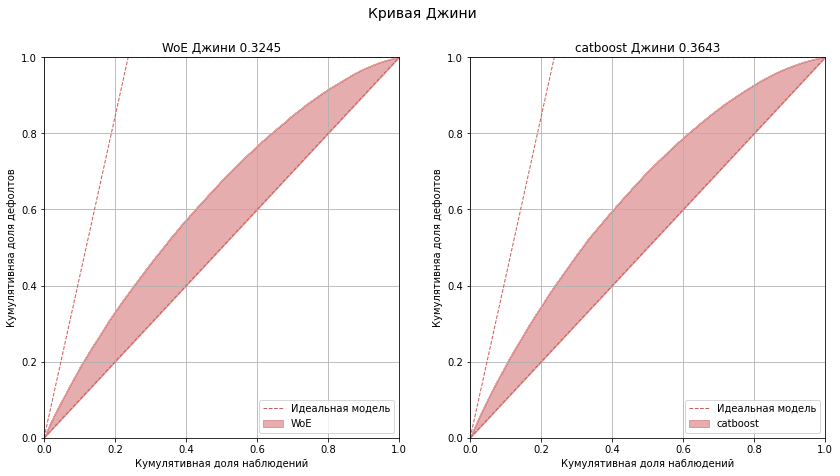

In [30]:
def gini_curve(sample, score_field, name):
    x = sample[sample["target"] != -1].copy()
    x = x[[score_field, "target"]].sort_values(score_field, ascending=False).copy()

    gini = roc_auc_score(x["target"], x[score_field]) * 2 - 1
    cumsum_obs = np.arange(1, 1 + len(x)) / len(x)
    cumsum_def = np.cumsum(x["target"]).values / x["target"].sum()
    cumsum_ideal_def = np.hstack(
        [np.arange(1, 1 + x["target"].sum()) / x["target"].sum(), np.ones(len(x) - x["target"].sum())]
    )

    plt.plot(cumsum_obs, cumsum_ideal_def, linewidth=1, color="indianred", linestyle="--", label="Идеальная модель")
    plt.plot(cumsum_obs, cumsum_obs, linewidth=1, color="indianred", linestyle="--")
    plt.fill_between(cumsum_obs, cumsum_def, cumsum_obs, alpha=0.5, color="indianred", label=name)

    plt.xlabel("Кумулятивная доля наблюдений")
    plt.ylabel("Кумулятивняа доля дефолтов")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.legend()
    plt.grid()

    plt.title(f"{name} Джини {gini:.4f}")


plt.figure(figsize=(14, 7), facecolor="w")
plt.subplot(1, 2, 1)
gini_curve(samples_woe["oot"], "score", "WoE")

plt.subplot(1, 2, 2)
gini_curve(samples_woe["oot"], "score_cb", "catboost")

plt.suptitle("Кривая Джини", fontsize=14)
plt.show()

In [35]:
features

['inq_fi',
 'all_util',
 'home_ownership',
 'log_annual_inc',
 'annual_inc',
 'num_rev_tl_bal_gt_0',
 'mort_acc',
 'funded_amnt_inv',
 'emp_title',
 'bc_open_to_buy',
 'debt_load',
 'fico_range_low',
 'fico_range_high']

In [84]:
samples['oos']['num_rev_tl_bal_gt_0']

0         15.0
1          6.0
2         16.0
3          3.0
4          4.0
          ... 
396550     4.0
396551     3.0
396552    15.0
396553     3.0
396554     4.0
Name: num_rev_tl_bal_gt_0, Length: 396555, dtype: float64

In [11]:
s = 'emp_title'
a = samples['oos'][s]#.sample(30_000)
a = a[~a.isna()].sample(30_000)
b = samples['oot'][s].sample(30_000)


In [12]:
samples['oos'][s].value_counts()

__other__       265254
__none__         24020
teacher           8165
manager           7600
owner             4800
                 ...  
agent              304
realtor            303
loan officer       301
instructor         301
counselor          300
Name: emp_title, Length: 115, dtype: int64

In [13]:
samples['oot'][s].value_counts()

__other__            557797
__none__              87003
teacher               21210
manager               20679
owner                 17153
                      ...  
regional manager        789
business manager        782
letter carrier          751
vp                      710
senior accountant       669
Name: emp_title, Length: 115, dtype: int64

In [14]:
x  = samples["oos"].groupby("issue_d").apply(lambda x: pd.Series({"nan": x[s].isna().mean(), "size": len(x)}))
x[x['nan'] < 1]

,nan,size
issue_d,,
2007-06-01,0.0,5.0
2007-07-01,0.0,14.0
2007-08-01,0.0,19.0
2007-09-01,0.0,18.0
2007-10-01,0.0,35.0
...,...,...
2016-08-01,0.0,10971.0
2016-09-01,0.0,8484.0
2016-10-01,0.0,9808.0


Text(0.5, 1.0, 'emp_title NaN rate')

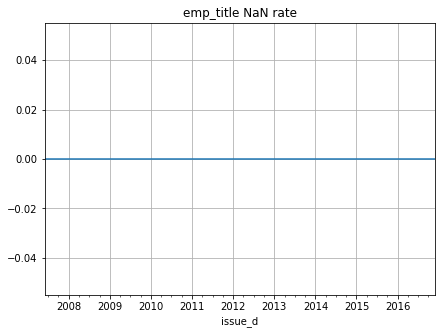

In [15]:
plt.figure(figsize=(7,5), facecolor='w')
samples["oos"].groupby("issue_d").apply(lambda x: pd.Series({"nan": x[s].isna().mean(), "size": len(x)}))['nan'].plot()
plt.grid()
plt.title(f'{s} NaN rate')

In [16]:
a.isna().mean(), a.isna().mean(), b.isna().mean()

(0.0, 0.0, 0.0)

(array([23621.,  1283.,   945.,   717.,   549.,   927.,   481.,   516.,
          506.,   455.]),
 array([  0. ,  11.4,  22.8,  34.2,  45.6,  57. ,  68.4,  79.8,  91.2,
        102.6, 114. ]),
 <BarContainer object of 10 artists>)

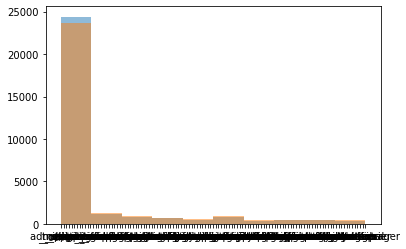

In [17]:
plt.hist(a, label='oos', alpha=0.5)
plt.hist(b, label='oot', alpha=0.5)

# Uplift

In [18]:
# Перемешивание колонки для uplift
import contextlib


@contextlib.contextmanager
def column_shuffler(df, col, rs):
    orig = df[col].copy()
    df[col] = df[col].sample(frac=1, random_state=rs).values
    try:
        yield df
    finally:
        df[col] = orig

In [46]:
import pickle
from autowoe import AutoWoE, ReportDeco

with open("/home/asciishell/s3/jupyter.asciishell.ru/auto_woe.pkl", "rb") as f:
    auto_woe = pickle.load(f)

In [47]:
features_woe = list(auto_woe.get_model_represenation()["features"].keys())
features_woe

['fico_range_high',
 'debt_load',
 'verification_status',
 'bc_open_to_buy',
 'tot_hi_cred_lim',
 'mort_acc',
 'total_bc_limit',
 'home_ownership',
 'num_rev_tl_bal_gt_0',
 'purpose']

In [48]:
x = samples['oos'][samples['oos']['target'] != -1].copy()
imp = []
for i, f in enumerate(tqdm(features_woe)):
    with column_shuffler(x, f, 42) as dfs:
        proba = auto_woe.predict_proba(dfs[features_woe])
        imp.append({
            'feature': f,
            'imp': roc_auc_score(dfs['target'], proba)
        })
imp = pd.DataFrame(imp).sort_values('imp').reset_index(drop=True)
imp

  0%|          | 0/10 [00:00<?, ?it/s]

,feature,imp
0,debt_load,0.606530
1,fico_range_high,0.612719
2,verification_status,0.627445
3,num_rev_tl_bal_gt_0,0.630014
4,total_bc_limit,0.635495
5,purpose,0.636738
6,mort_acc,0.637233
7,home_ownership,0.639121
8,bc_open_to_buy,0.641050
9,tot_hi_cred_lim,0.641124


In [55]:
uplift = []
for thr in tqdm(
    sorted(
        set(np.percentile(imp["imp"], np.linspace(0, 100, 20), interpolation="midpoint"))
        # | set(np.percentile(imp["imp"], np.linspace(0, 20, 20), interpolation="midpoint"))
        | set([imp["imp"].max()])
    )
):
    features2 = imp[imp["imp"] <= thr]["feature"].values.copy()

    clf_ = AutoWoE(
        monotonic=True,
        max_bin_count=4,
        pearson_th=0.9,
        vif_th=10.0,
        auc_th=0.53,
        imp_th=0.001,
        th_const=32,
        force_single_split=True,
        min_bin_size=0.05,
        oof_woe=True,
        n_folds=5,
        n_jobs=26,
        regularized_refit=True,
        verbose=0,
    )

    clf_.fit(
        samples["train"][samples["train"]["target"] != -1][[*features2, 'target']],
        target_name='target',
        validation=samples["oos"][samples["oos"]["target"] != -1][[*features2, 'target']],
        features_type=dict(zip(features2, ["cat" if f in cat_features else "real" for f in features2])),
    )
    x = samples["train"][samples["train"]["target"] != -1]
    proba = clf_.predict_proba(x[features2])
    mtrain = roc_auc_score(x["target"], proba)

    x = samples["oos"][samples["oos"]["target"] != -1]
    proba = clf_.predict_proba(x[features2])
    moos = roc_auc_score(x["target"], proba)

    x = samples["oot"][samples["oot"]["target"] != -1]
    proba = clf_.predict_proba(x[features2])
    moot = roc_auc_score(x["target"], proba)

    uplift.append(
        {
            "columns": len(features2),
            "features": features2,
            "train_score": mtrain,
            "oos_score": moos,
            "oot_score": moot,
        }
    )
uplift = pd.DataFrame(uplift)
uplift

  0%|          | 0/11 [00:00<?, ?it/s]

[LightGBM] [Warning] Starting from the 2.1.2 version, default value for the "boost_from_average" parameter in "binary" objective is true.
This may cause significantly different results comparing to the previous versions of LightGBM.
Try to set boost_from_average=false, if your old models produce bad results
[LightGBM] [Info] Number of positive: 118670, number of negative: 471702
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data: 590372, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201009 -> initscore=-1.380001
[LightGBM] [Info] Start training from score -1.380001
[LightGBM] [Warning] Starting from the 2.1.2 version, default value for the "boost_from_average" parameter in "binary" objective is true.
This may cause significantly different results comparing to the previous versions of LightGBM.
Try to set boost_from_average=false, if your old models produce bad results
[LightGBM] [Info] Number of positive: 118670, number of negative: 471702


,columns,features,train_score,oos_score,oot_score
0,1,[debt_load],0.579412,0.577234,0.604760
1,1,[debt_load],0.579412,0.577234,0.604760
2,2,"[debt_load, fico_range_high]",0.619725,0.616879,0.635572
3,3,"[debt_load, fico_range_high, verification_status]",0.619725,0.616879,0.635572
4,4,"[debt_load, fico_range_high, verification_stat...",0.623965,0.621194,0.640115
5,5,"[debt_load, fico_range_high, verification_stat...",0.629445,0.626952,0.644449
6,6,"[debt_load, fico_range_high, verification_stat...",0.629445,0.626952,0.644449
7,7,"[debt_load, fico_range_high, verification_stat...",0.633491,0.630791,0.653537
8,8,"[debt_load, fico_range_high, verification_stat...",0.634528,0.631801,0.655904
9,9,"[debt_load, fico_range_high, verification_stat...",0.634586,0.631848,0.656714


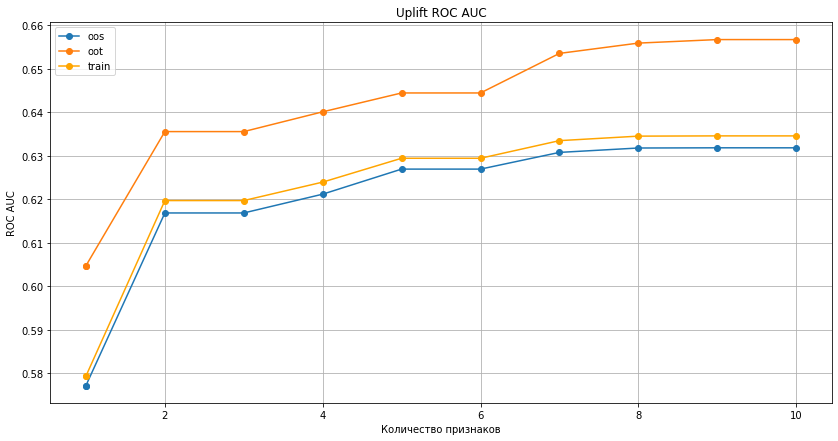

In [56]:
plt.figure(figsize=(14, 7), facecolor='w')
plt.plot(uplift['columns'], uplift['oos_score'], marker='o', label='oos')
plt.plot(uplift['columns'], uplift['oot_score'], marker='o', label='oot')
plt.plot(uplift['columns'], uplift['train_score'], marker='o', color='orange', label='train')

plt.title('Uplift ROC AUC')
plt.legend()
plt.xlabel('Количество признаков')
plt.ylabel('ROC AUC')
# plt.twinx()
plt.grid()

### CatBoost

In [19]:
x = samples['oos'][samples['oos']['target'] != -1].copy()
imp = []
for i, f in enumerate(tqdm(features)):
    with column_shuffler(x, f, 42) as dfs:
        proba = clf.predict_proba(dfs[features])[:, 1]
        imp.append({
            'feature': f,
            'imp': roc_auc_score(dfs['target'], proba)
        })
imp = pd.DataFrame(imp).sort_values('imp').reset_index(drop=True)
imp

  0%|          | 0/11 [00:00<?, ?it/s]

,feature,imp
0,funded_amnt_inv,0.574779
1,debt_load,0.582950
2,log_annual_inc,0.630275
3,annual_inc,0.643108
4,num_rev_tl_bal_gt_0,0.664514
5,emp_title,0.665335
6,fico_range_low,0.667940
7,bc_open_to_buy,0.668643
8,mort_acc,0.668748
9,fico_range_high,0.669537


In [20]:
uplift = []
for thr in tqdm(
    sorted(
        set(np.percentile(imp["imp"], np.linspace(0, 100, 20), interpolation="midpoint"))
        # | set(np.percentile(imp["imp"], np.linspace(0, 20, 20), interpolation="midpoint"))
        | set([imp["imp"].max()])
    )
):
    features2 = imp[imp["imp"] <= thr]["feature"].values.copy()
    pools2 = {
        k: catboost.Pool(
            v[v["target"] != -1][features2],
            v[v["target"] != -1]["target"],
            cat_features=sorted(set(features2) & set(cat_features)),
        )
        for k, v in samples.items()
    }
    clf_ = catboost.CatBoostClassifier(**params)
    clf_.fit(pools2["train"], eval_set=pools2["oos"], verbose=0, plot=False)

    x = samples["train"][samples["train"]["target"] != -1]
    proba = clf_.predict_proba(x[features2])[:, 1]
    mtrain = roc_auc_score(x["target"], proba)

    x = samples["oos"][samples["oos"]["target"] != -1]
    proba = clf_.predict_proba(x[features2])[:, 1]
    moos = roc_auc_score(x["target"], proba)

    x = samples["oot"][samples["oot"]["target"] != -1]
    proba = clf_.predict_proba(x[features2])[:, 1]
    moot = roc_auc_score(x["target"], proba)

    uplift.append(
        {
            "columns": len(features2),
            "features": features2,
            "train_score": mtrain,
            "oos_score": moos,
            "oot_score": moot,
        }
    )
uplift = pd.DataFrame(uplift)
uplift

  0%|          | 0/12 [00:00<?, ?it/s]

,columns,features,train_score,oos_score,oot_score
0,1,[funded_amnt_inv],0.564959,0.563601,0.571316
1,1,[funded_amnt_inv],0.564959,0.563601,0.571316
2,2,"[funded_amnt_inv, debt_load]",0.595954,0.592628,0.615156
3,3,"[funded_amnt_inv, debt_load, log_annual_inc]",0.634206,0.626421,0.618996
4,4,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.637083,0.628340,0.620419
5,5,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.646043,0.637673,0.631454
6,6,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.651147,0.642468,0.637588
7,7,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.675979,0.667424,0.662960
8,8,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.678477,0.669379,0.666834
9,9,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.684496,0.674955,0.679189


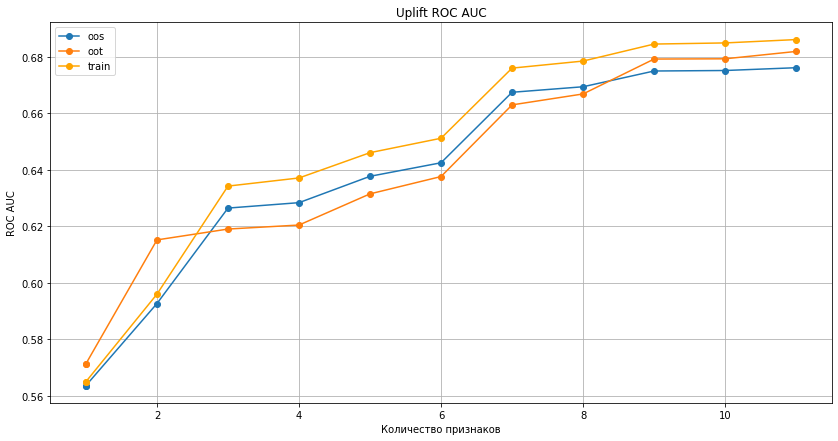

In [21]:
plt.figure(figsize=(14, 7), facecolor='w')
plt.plot(uplift['columns'], uplift['oos_score'], marker='o', label='oos')
plt.plot(uplift['columns'], uplift['oot_score'], marker='o', label='oot')
plt.plot(uplift['columns'], uplift['train_score'], marker='o', color='orange', label='train')

plt.title('Uplift ROC AUC')
plt.legend()
plt.xlabel('Количество признаков')
plt.ylabel('ROC AUC')
# plt.twinx()
plt.grid()

# Калибровка

In [22]:
clf = catboost.CatBoostClassifier(**params)
clf.load_model('catboost.cb')

In [23]:
calibration_res =[]
for k, v in samples.items():
    s = v[v["target"] != -1]
    y_true = s['target'].values
    y_score = clf.predict_proba(s[features])[:, 1]
    
    lb, ub = [x / len(s) for x in ss.binom.interval(n=len(s), p=y_score.mean(), alpha=0.95)]
    calibration_res.append({
        'sample': k,
        'TR': y_true.mean(),
        'SR': y_score.mean(),
        'LB': lb,
        'UB': ub,
        'OK': lb <=  y_true.mean() <= ub,
    })
calibration_res = pd.DataFrame(calibration_res).round(4)
calibration_res['sample'] = [x + (' 🟢' if y else ' 🔴') for x, y in zip(calibration_res['sample'].values, calibration_res['OK'].values)]
calibration_res

,sample,TR,SR,LB,UB,OK
0,train 🟢,0.2014,0.2013,0.2004,0.2022,True
1,oos 🟢,0.2025,0.2017,0.2003,0.2031,True
2,oot 🔴,0.2365,0.1850,0.1834,0.1866,False


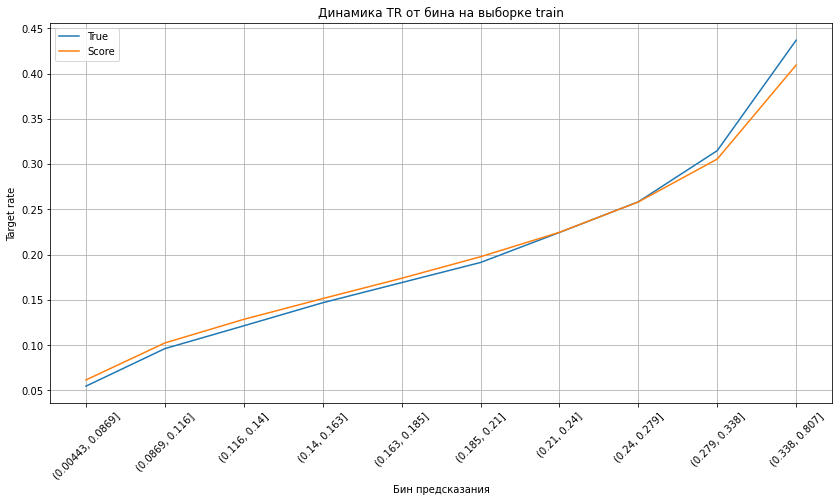

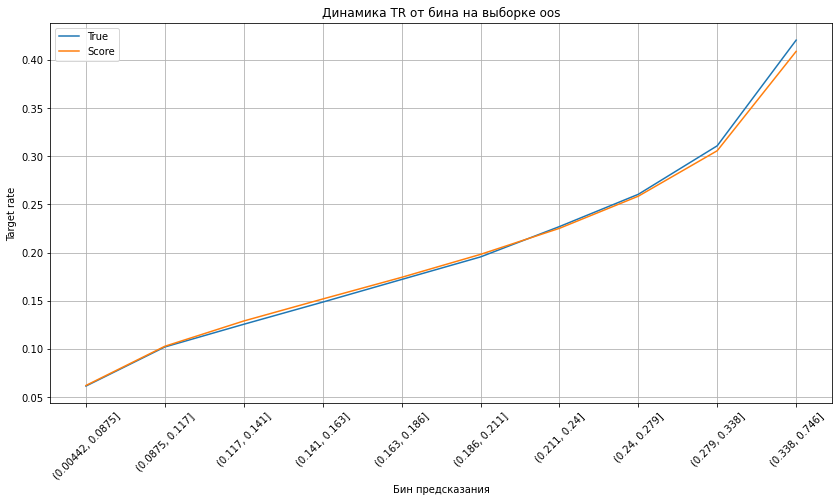

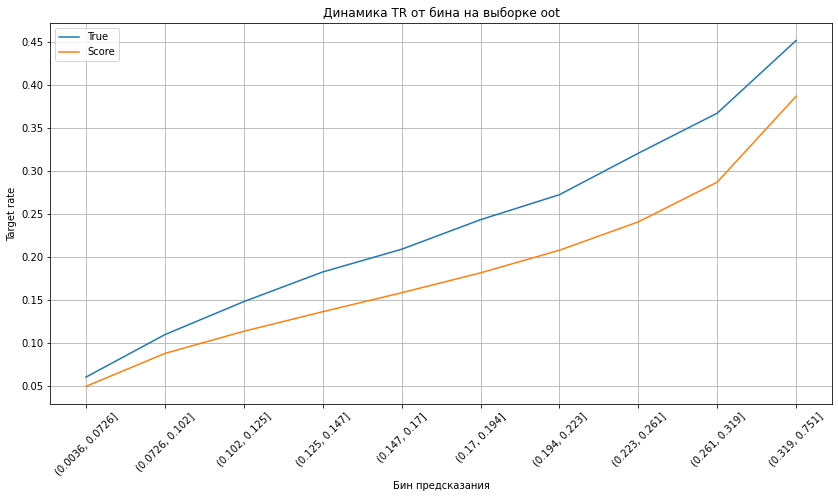

In [24]:
for k, v in samples.items():
    x = v[v["target"] != -1]
    y_true = x['target'].values
    y_score = clf.predict_proba(x[features])[:, 1]
    data = pd.DataFrame({'true': y_true, 'score': y_score})
    x = data.assign(q=pd.qcut(data['score'], q=10, duplicates='drop')).groupby('q').agg('mean')
    xi = np.arange(len(x))
    plt.figure(figsize=(14, 7), facecolor='w')
    plt.plot(xi, x['true'].values, label='True')
    plt.plot(xi, x['score'].values, label='Score')
    plt.xticks(xi, x.index, rotation=45)

    plt.xlabel('Бин предсказания')
    plt.ylabel('Target rate')
    plt.title(f'Динамика TR от бина на выборке {k}')
    plt.grid()
    plt.legend()
    plt.show()

# Feature gini

  0%|          | 0/11 [00:00<?, ?it/s]

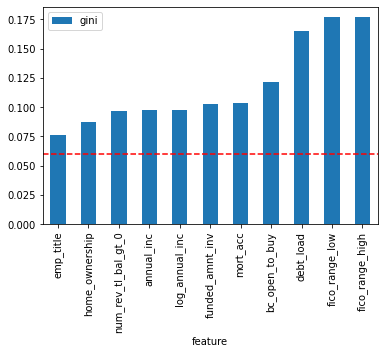

In [25]:
feature_gini = []

# x = samples["oos"][samples["oos"]["target"] != -1]
for f in tqdm(features):
    clf_ = catboost.CatBoostClassifier(iterations=50, depth=1, eval_metric='AUC', ignored_features=sorted(set(features) - {f}))
    clf_.fit(
        pools["train"],
        eval_set=pools["oos"],
        verbose=0,
        # plot=True,
    )
    # metric = roc_auc_score(x['target'], clf.predict_proba(pools['oos'])[:, 1])
    metric = clf_.best_score_['validation']['AUC']
    feature_gini.append({
        'feature': f,
        'gini': metric * 2 - 1,
    })
feature_gini = pd.DataFrame(feature_gini).sort_values('gini')
feature_gini.plot.bar(x='feature')
plt.axhline(0.06, linestyle='--', color='r')

# Shap

In [26]:
import shap
shap.initjs()

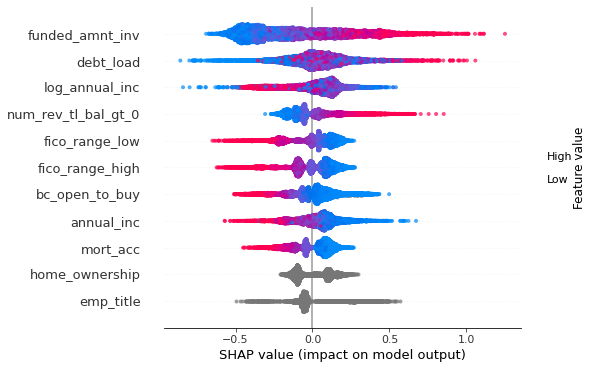

In [27]:
X = samples["oos"][samples["oos"]["target"] != -1][clf.feature_names_].sample(10_000, random_state=42).copy()

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, max_display=20, alpha=0.7)